In [1]:
# Copyright 2023 Andrew Lehr
# The MIT LICENSE

# # Dynamic control of neural manifolds
#### Lehr, Kumar, & Tetzlaff

####
### Code to produce Figure 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import os

from scipy.optimize import curve_fit
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert

from submanifolds.utils import get_root
from submanifolds.ringnet.network import RingNetworkVariableSpeed
from submanifolds.ringnet import Parameters
from submanifolds.ringnet import Plot
from submanifolds.utils import get_root

### Color palettes

In [2]:
colors = ['#586ba4', '#f68e5f', '#f5dd90',  
          '#067d7a', '#77c1b3',  '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

### Manage directories

In [3]:
root = get_root()
save_figs_flag = 0

# Figure storage
fig_top_dir = root + 'figures/'
fig_dir = fig_top_dir + 'figure_4/'

# Data storage
data_top_dir = root + 'data/'
data_dir = data_top_dir + 'speed_control/'

if not os.path.isdir(fig_top_dir):
    os.mkdir(fig_top_dir)
    print('Created ' + fig_top_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('fig dir exists')

if not os.path.isdir(data_top_dir):
    os.mkdir(data_top_dir)
    print('Created ' + data_top_dir)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    print('Created ' + data_dir)
else:
    print('data dir exists')

fig dir exists
data dir exists


In [4]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

### Parameters

In [5]:
sigma = 0.04
shift = 0.04
_w_E = 5 
N = 1000
T = 2001 
tau = 100 

n_seeds = 1
seeds = np.arange(n_seeds)

# speed control
speeds = np.arange(1,26,1).round(2) 
n_speeds = len(speeds)

# shape control
shapes = [0] 
n_shapes = len(shapes)
t_shape_input = (T-1)/2
sd_shape_input = 12 

# subspaces
perc_sel = [0] 
n_perc_sel = len(perc_sel)

# shape 2 -- activation function maxima
r_max_vals = [0] 
n_r_max_vals = len(r_max_vals)
r_max = np.ones((T,N))

active_neurons = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
average_rate = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
raster = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,N,T))

In [6]:
n_speeds * n_shapes * n_perc_sel * n_r_max_vals * n_seeds

25

## Functions

In [7]:
def center_raster(raster, normalize=True):
    # center the data
    R_centered = raster - raster.mean(axis=1, keepdims=True)
    if normalize:
        std = raster.std(axis=1, keepdims=True)
        R_centered = np.divide(R_centered, std, where=std!=0)
    return R_centered

In [8]:
def compute_pca(raster, n_components=2, normalize=True, compute_trajectory=False):

    # center and normalize, returns 
    centered_raster = center_raster(raster, normalize)
        
    # compute PCA
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(centered_raster.T)

    if compute_trajectory:
        # project onto PCs
        trajectory = project_onto_basis(centered_raster, pca.components_)
    else:
        trajectory = None
    
    return pca, trajectory, centered_raster

In [9]:
def project_onto_basis(raster, basis):
    return basis @ raster

In [10]:
def compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    diff = np.sqrt(np.sum((trajectory_1 - trajectory_2)**2, axis=0))
    peak_loc = t0 + np.argmax(diff[input_range])
    sign_diff = np.sign(np.sqrt(np.sum(trajectory_1[:,peak_loc]**2)) - np.sqrt(np.sum(trajectory_2[:,peak_loc]**2)))
    max_diff = sign_diff * diff[peak_loc] / np.sqrt(np.sum(trajectory_2[:,peak_loc]**2))

    return max_diff

In [11]:
def compute_trajectory_perturbation_from_raster(raster_1, raster_2, basis, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    tol = .00001
    if (np.abs(raster_1.mean(axis=1)) > tol).any() or (np.abs(raster_2.mean(axis=1)) > tol).any():
        print("NOT CENTERED!")

    trajectory_1 = project_onto_basis(raster_1, basis)
    trajectory_2 = project_onto_basis(raster_2, basis)

    max_diff = compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center, t_half_width)

    return max_diff

In [12]:
def compute_trajectory_rotational_speed(raster, basis):
    trajectory = project_onto_basis(raster, basis)
    analytic_signal = hilbert(trajectory)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    initial_phase = np.min(instantaneous_phase, axis=1, keepdims=True)
    instantaneous_phase = instantaneous_phase - initial_phase
    n_rotations = np.mean(np.max(instantaneous_phase, axis=1, keepdims=True)/(2*np.pi))
    return n_rotations

In [13]:
def compute_bump_speed(raster, thr_act = 0, thr_sep = 500):
    N = np.shape(raster)[0]
    T = np.shape(raster)[1]
    bump_center = np.zeros(T)
    pos_cumulative = np.zeros(T)
    for t in range(T):
        neurons_above_thr = np.where(raster[:,t] > thr_act)[0]
        if (np.max(neurons_above_thr) - np.min(neurons_above_thr)) > thr_sep:
            neurons_above_thr[neurons_above_thr<thr_sep] += N
        bump_center[t] = np.mean(neurons_above_thr) % N

    bump_speed = (bump_center[1:] - bump_center[:-1]) % N

    pos_cumulative[0] = bump_center[0]
    for k in range(1,T):
        pos_cumulative[k] = bump_center[0] + np.sum(bump_speed[:k])
    return bump_center, bump_speed, pos_cumulative

In [14]:
def compute_maximum_relative_bump_width(active_neurons, active_neurons_ref, t_center=t_shape_input, t_half_width=2*sd_shape_input):
    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    bump_width = (active_neurons[input_range] - active_neurons_ref[input_range]) / active_neurons_ref[input_range]
    max_loc = np.argmax(np.abs(bump_width))
    max_rel_width = bump_width[max_loc]
    return max_rel_width

In [15]:
def compute_subspace_angle(basis_1, basis_2):
    u, s, vh = np.linalg.svd(np.dot(basis_1, basis_2.T), full_matrices=True)
    angles = np.arccos(np.clip(s, -1, 1))*180/np.pi
    return angles.mean()

In [16]:
def compute_subspace_angle_from_raster(raster_1, raster_2):
    pca_1 = compute_pca(raster_1)[0]
    pca_2 = compute_pca(raster_2)[0]
    basis_1 = pca_1.components_
    basis_2 = pca_2.components_
    angle = compute_subspace_angle(basis_1, basis_2)
    return angle

In [17]:
class Status:
    def __init__(self, total_iterations):
        self.total_iterations = total_iterations
        self.current_iteration = 0

    def it(self):
        self.current_iteration +=1
        print('\r: ' + str(self.current_iteration) + '/' + str(self.total_iterations), end='')

In [18]:
def compile_aggregate_raster(rasters):
    shape = np.shape(rasters)
    N = np.shape(rasters)[-2]
    T = np.shape(rasters)[-1]
    
    joint_raster = np.zeros((N,1))
    for speed_i in range(n_speeds):
        for shape_i in range(n_shapes):
            joint_raster = np.concatenate([joint_raster, rasters[:,:,speed_i,shape_i]], axis=1)
        
    joint_raster = joint_raster[:,1:]
    return joint_raster

## Run simulations

In [19]:
for p_i, p in enumerate(perc_sel):
    for k, seed in enumerate(seeds):
        params_to_update = {'keys':     ['N','sigma_percent', 'shift_percent', 'T', '_w_E', 'p_inh', 'seed', 'stim', 'type'], 
                            'setting':  [N, sigma, shift, T, _w_E, p, seed, 'transient', 'projection']}

        params = Parameters(params_to_update)

        # generate initial condition
        S = speeds[0]*np.ones(T)
        net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max) 
        initial_t = 250
        center = 0
        x = net.params.x
        width = int(net.params.sigma)
        max_active = net.params.P * r_max[0]
        initial_r = max_active * np.exp(-0.5 * (x - center)**2 / (width)**2)
        params.initial_r = initial_r
        net.run()
        initial_r = net.R[:,initial_t]
        #plt.plot(initial_r)
        params.initial_r = initial_r

        for j, A in enumerate(shapes):
            I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input)

            for i, I_E in enumerate(speeds):
                #I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input[i])
                S = I_E*np.ones(T)
                net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max, I_ext=I_ext) 
                net.run()
                active_neurons[p_i,i,j,k,:] = np.sum(net.R > 0, axis=0)
                average_rate[p_i,i,j,k,:] = np.mean(net.R, axis=0)
                raster[p_i,i,j,k,:,:] = net.R
    print(p)

/home/andrew/Documents/projects/submanifolds/submission_dynamic_control/code/submanifolds/ringnet/parameters.py:66: UserWarning: Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.
  warnings.warn('Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.')


0


### Figure 4g: Plot example rasters

In [20]:
plot = Plot()

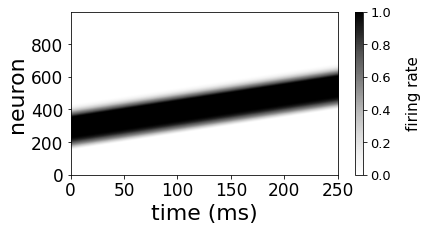

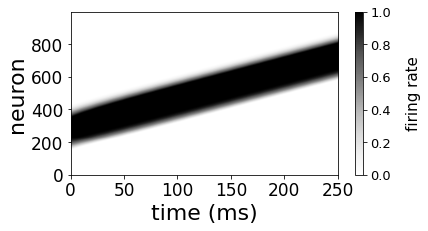

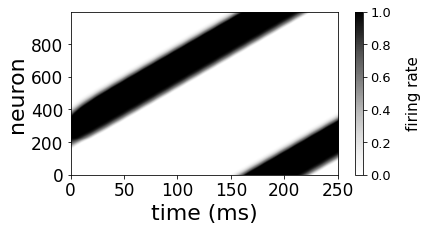

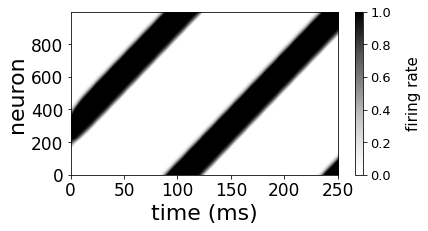

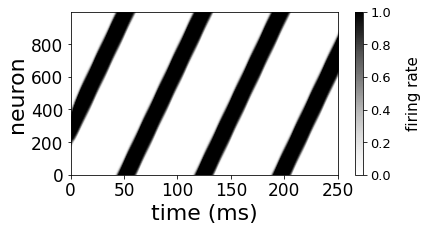

In [21]:
fname='raster_S='
exs = [0,1,4,9,24]
perc = 0
traj = 0
seed = 0
for speed_i, speed in enumerate(exs):
    file = fig_dir+fname+str(speed+1)
    point = (perc, speed, traj, seed)
    plot.activity_raster(raster[point][:,0:251], xlabel='time (ms)', labelsize=22, storage_loc=file)

### Figure 4d: Weight Matrix

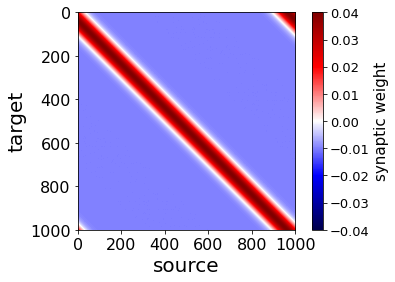

In [22]:
#plot = Plot()
fname = 'weight_matrix'
#plt.imshow(net.W, cmap='seismic', vmin=-.04, vmax=0.04) #, storage_loc=fig_dir+fname)
tick_sep = 200
fig, ax = plt.subplots()
im = ax.imshow(net.W, cmap='seismic', vmin=-.04, vmax=0.04)
cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=13)
cb.set_label('synaptic weight', fontsize=15)
ax.set_xticks(np.arange(0,np.shape(net.W)[1]+1,tick_sep))
ax.set_yticks(np.arange(0,np.shape(net.W)[0]+1,tick_sep))
ax.set_xticklabels(np.arange(0,np.shape(net.W)[1]+1,tick_sep), fontsize=16)
ax.set_yticklabels(np.arange(0,np.shape(net.W)[0]+1,tick_sep), fontsize=16)
ax.set_xlabel('source', fontsize=20)
ax.set_ylabel('target', fontsize=20)

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()

#plt.colorbar()

### Figure 4e: Eigenspectrum

In [23]:
vals_W = np.zeros((n_speeds,N), dtype=complex)
vecs_W = np.zeros((n_speeds,N,N), dtype=complex)
for i in range(n_speeds):
    vals_W[i,:], vecs_W[i,:,:] = np.linalg.eig(speeds[i] * net.W)

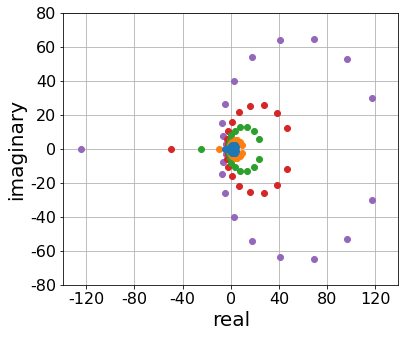

In [24]:
fname='eigenspectrum'

fig, ax = plt.subplots(figsize=(6,5))
for ex_i in exs:
    ax.scatter(vals_W[ex_i,:].real, vals_W[ex_i,:].imag, zorder=25-ex_i, label='S='+str(speeds[ex_i]))

ax.set_xlabel('real', fontsize=20)
ax.set_ylabel('imaginary', fontsize=20)

ax.set_xticks(np.arange(-120,150,40))
ax.set_xticklabels(np.arange(-120,150,40), fontsize=16)
ax.set_yticks(np.arange(-80,90,20).round(1))
ax.set_yticklabels(np.arange(-80,90,20).round(1), fontsize=16)

ax.set_xlim(-139,139)
ax.set_axisbelow(True)
ax.grid()

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()

## Magnitude of maximum eigenvalue vs. speed population input
Both real and imaginary parts grow. Imaginary part leads to increase in speed. We make the assumption we are working near the neurons peak firing rates and that further increase in real part does not lead to runaway activity.

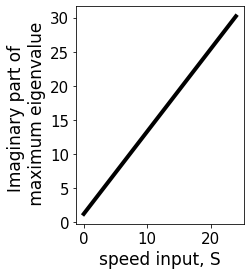

In [25]:
fname = 'imag_part_max_eigenvalue'
argmax_eval = np.argmax(np.abs(vals_W*(vals_W > 0)), axis=1)
index = np.arange(0,n_speeds)
fig, ax = plt.subplots(1,1, figsize=(3,4))
ax.plot(vals_W[index, argmax_eval].imag, label='imaginary', color='black', linewidth=4)
plt.xlabel('speed input, S', fontsize=17)
plt.ylabel('Imaginary part of \n maximum eigenvalue', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()

### Figure 4f: Bump speed vs. speed population input

In [26]:
centers = np.zeros((n_speeds, T))
pos_cumulative = np.zeros((n_speeds, T))
bump_speed = np.zeros((n_speeds, T-1))
perc = 0
traj = 0
seed = 0
for speed_i, speed in enumerate(speeds):
    point = (perc, speed_i, traj, seed)
    centers[speed_i,:], bump_speed[speed_i,:], pos_cumulative[speed_i,:] = compute_bump_speed(raster[point])

In [27]:
bump_speed.mean(axis=1)

array([ 0.99925,  1.727  ,  2.4315 ,  3.11425,  3.776  ,  4.4185 ,
        5.042  ,  5.6475 ,  6.2365 ,  6.80825,  7.36425,  7.907  ,
        8.432  ,  8.94775,  9.4445 ,  9.93275, 10.41075, 10.86975,
       11.31825, 11.7625 , 12.1995 , 12.61775, 13.02225, 13.41675,
       13.805  ])

In [28]:
perc = 0
seed = 0
traj = 0
joint_raster = np.zeros((N,1))
for speed in range(n_speeds):
    point = (perc, speed, traj, seed)
    joint_raster = np.concatenate([joint_raster, raster[point]], axis=1)

joint_raster = joint_raster[:,1:]
joint_pca, _, raster_centered = compute_pca(joint_raster, n_components=6)

In [31]:
perc = 0
speed = 0
traj = 0
seed = 0
point = (perc, speed, traj, seed)

pca_baseline, _, raster_centered_ = compute_pca(raster[point], n_components=6)
basis = pca_baseline.components_

In [32]:
from scipy.signal import hilbert

rotations = np.zeros((6,n_speeds))
for i in range(n_speeds):
    prj = project_onto_basis(raster_centered[:,i*T: (i+1)*T], basis)

    analytic_signal = hilbert(prj)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    rotations[:,i] = (instantaneous_phase[:,-1] - instantaneous_phase[:,0]) / (2*np.pi)

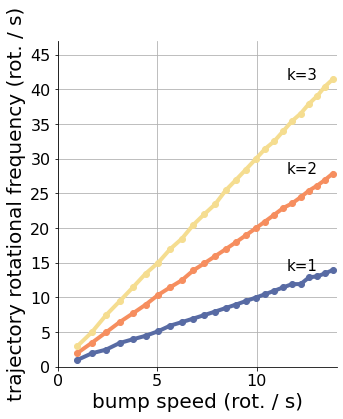

In [33]:
fname = 'trajectory_rot_freq_vs_bump_freq'
fig, ax = plt.subplots(figsize=(5,6))

for i in range(3):
    ax.plot(bump_speed.mean(axis=1), rotations[2*i,:].T/(T/1000), color=colors[i], linewidth=4, marker='o')
    ax.text(x=11.5,y=rotations[2*i,-1]/(T/1000), s='k=' + str(i+1), fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.arange(0,15,5))
ax.set_xticklabels(np.arange(0,15,5), fontsize=16)
ax.set_yticks(np.arange(0,50,5).round(1))
ax.set_yticklabels(np.arange(0,50,5).round(1), fontsize=16)
ax.set_xlabel('bump speed (rot. / s)', fontsize=20)
ax.set_ylabel('trajectory rotational frequency (rot. / s)', fontsize=20)

ax.set_xlim(0,14)
ax.set_ylim(0,47)
ax.set_axisbelow(True)
ax.grid()

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()

### Bump speed as function of gain modulation S

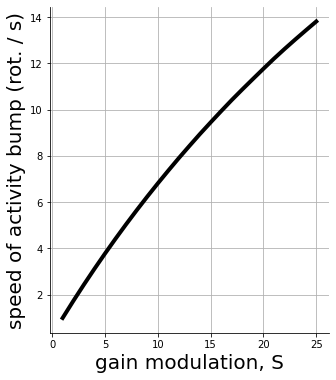

In [35]:
fname='bump_speed'
fig, ax = plt.subplots(1,1, figsize=(5,6))
ax.plot(speeds, bump_speed.mean(axis=1), color='black',linewidth=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('gain modulation, S', fontsize=20)
ax.set_ylabel('speed of activity bump (rot. / s)', fontsize=20)
ax.grid()

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()


### Figure 4c: Bump speed as function of gain modulation S

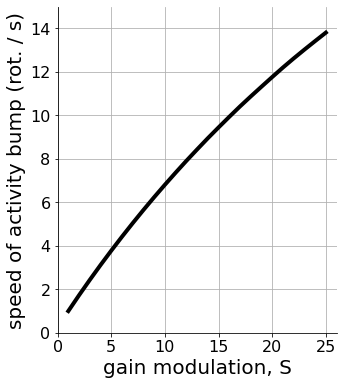

In [34]:
fname='bump_speed'
fig, ax = plt.subplots(1,1, figsize=(5,6))
ax.plot(speeds, bump_speed.mean(axis=1), color='black',linewidth=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.arange(0,30,5))
ax.set_xticklabels(np.arange(0,30,5), fontsize=16)
ax.set_yticks(np.arange(0,15,2).round(1))
ax.set_yticklabels(np.arange(0,15,2).round(1), fontsize=16)
ax.set_xlabel('gain modulation, S', fontsize=20)
ax.set_ylabel('speed of activity bump (rot. / s)', fontsize=20)

ax.set_xlim(0,26)
ax.set_ylim(0,15)
ax.grid()

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()


### Figure 4a: gain modulation S

In [36]:
prop_cycle = plt.rcParams['axes.prop_cycle']
speed_colors = prop_cycle.by_key()['color']

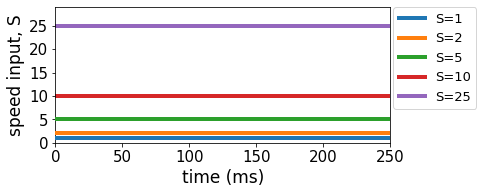

In [37]:
fname = 'speed_input'
plt.figure(figsize=(6,2.5))
for i, ex_i in enumerate(exs):
    plt.plot(np.arange(0,T), speeds[ex_i]*np.ones(T), linewidth=4, zorder=10-ex_i, label='S='+str(speeds[ex_i]), color=speed_colors[i])
plt.xlabel('time (ms)', fontsize=17)
plt.ylabel('speed input, S', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13, loc=(1.01,0.25))
plt.xlim(0,250)
plt.ylim(0,29)
if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()


### Figure 4b: bump speed over time

In [38]:
from scipy.ndimage import gaussian_filter

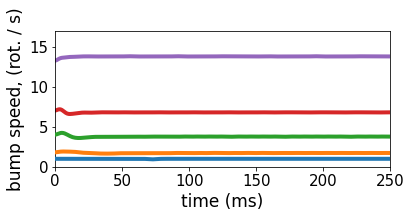

In [39]:
fname = 'bump_speed_over_time'
plt.figure(figsize=(6,2.5))
for i, ex_i in enumerate(exs):
    cv = gaussian_filter(np.gradient(pos_cumulative[ex_i, :500]), 3)
    plt.plot(np.arange(500), cv, linewidth=4, zorder=10-ex_i, label='S='+str(speeds[ex_i]),color=speed_colors[i])
plt.xlabel('time (ms)', fontsize=17)
plt.ylabel('bump speed, (rot. / s)', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,250)
plt.ylim(0,17)
if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()

### Figure 4g: projection into PC space

In [40]:
perc = 0
seed = 0
traj = 0
joint_raster = np.zeros((N,1))
for speed in range(n_speeds):
    point = (perc, speed, traj, seed)
    joint_raster = np.concatenate([joint_raster, raster[point]], axis=1)

joint_raster = joint_raster[:,1:]
joint_pca, _, raster_centered = compute_pca(joint_raster, n_components=6)

In [41]:
joint_pca.explained_variance_ratio_.cumsum()

array([0.28659052, 0.5713607 , 0.71697782, 0.86180407, 0.89707548,
       0.93210887])

In [42]:
perc = 0
speed = 0
traj = 0
seed = 0
point = (perc, speed, traj, seed)

pca_baseline, _, raster_centered_ = compute_pca(raster[point], n_components=6)
basis = pca_baseline.components_

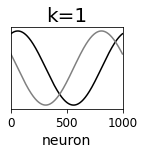

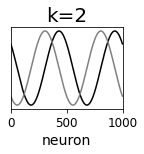

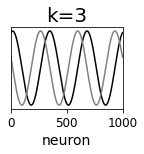

In [43]:
black_gray = ['black', 'gray']
for j in range(3):
    fname = 'principal_components_k=' + str(j+1)
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    for i in range(2):
        ax.plot(basis[2*j+i,:], color=black_gray[i])
    ax.set_xticks([0,500,1000], [0,500,1000], fontsize=12)
    ax.set_xlabel('neuron', fontsize=14)
    ax.set_yticks([])
    ax.set_xlim(0,1000)
    ax.set_title('k='+str(j+1), fontsize=20)
    if save_figs_flag:
        plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
        plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
    plt.show()

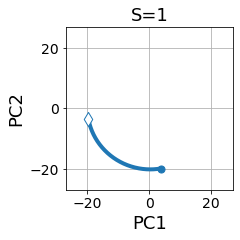

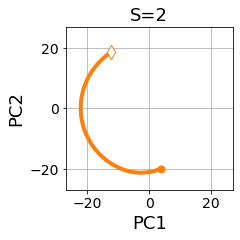

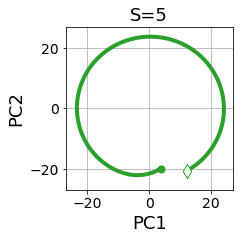

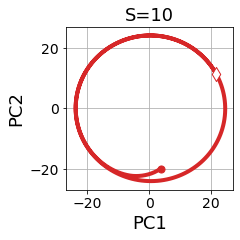

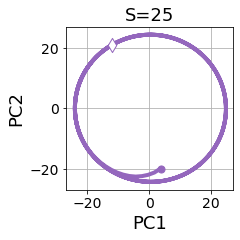

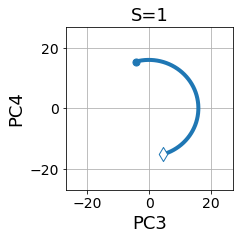

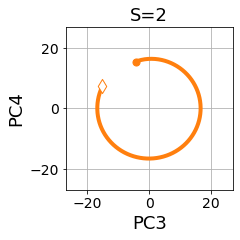

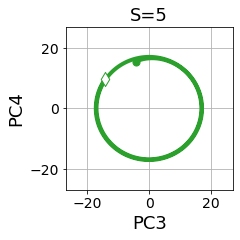

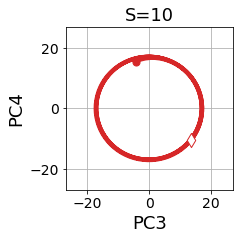

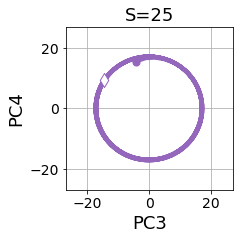

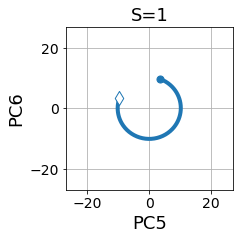

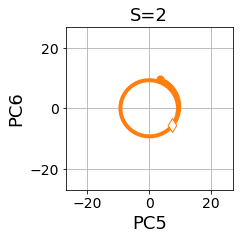

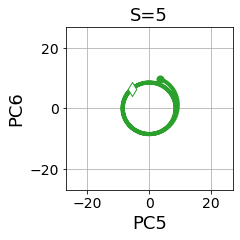

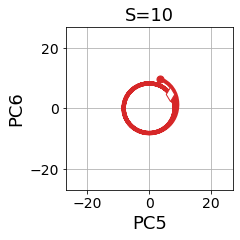

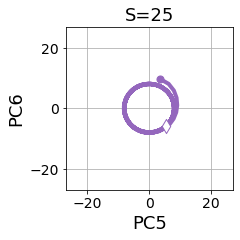

In [44]:
for j in range(3):
    for i, ex_i in enumerate(exs):
        fname = 'pc_projection_k=' + str(j+1) + '_S=' + str(ex_i+1)
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        prj = project_onto_basis(raster_centered[:,ex_i*T:ex_i*T+250], basis)
        ax.plot(*prj[2*j:2*(j+1),:],linewidth=4, zorder=n_speeds - i, alpha=1, color=speed_colors[i])
        ax.scatter(*prj[2*j:2*(j+1),0], s=50, color=speed_colors[i])
        ax.scatter(*prj[2*j:2*(j+1),-1], marker='d', s=100, edgecolor=speed_colors[i], facecolor='white', zorder= 10+n_speeds - i)
        ax.set_xlim(-27,27)
        ax.set_ylim(-27,27)
        ax.set_axisbelow(True)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel('PC'+str(2*j+1), fontsize=18)
        ax.set_ylabel('PC'+str(2*(j+1)), fontsize=18)
        ax.set_title('S=' + str(ex_i+1), fontsize=18)
        ax.grid()
        if save_figs_flag:
            plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
            plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
        plt.show()